# Document Setup

- Project ID: EMB_ex19
- Researchers: DK
- Current Version: v2.0

See associated protocol for more details.

In [236]:
# Stdlib
import os
import sys
import random
from collections import Counter
from datetime import datetime
from IPython.display import display, Latex

# Scientific computing
## Linear algebra
import numpy as np
from sklearn.linear_model import LogisticRegression

## Data processing
from sklearn.preprocessing import Normalizer, MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA

## Other
from sklearn.metrics import roc_auc_score

# Network science
import networkx as nx
from node2vec import Node2Vec as N2V

# Data handling and vis
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.lines import Line2D

# Project source
sys.path.append("../../src/")
import synthetic
import utils

# Miscellaneous
from tqdm.auto import tqdm

In [237]:
metadata = {
    "PROJECT_ID": "EMB_ex19",
    "RESEARCHERS": "DK",
    "CURRENT_VERSION": "v2.0",
    "DATE": datetime.today().strftime("%Y%m%d")
}
TAG = "{PROJECT_ID}{CURRENT_VERSION}_{RESEARCHERS}_{DATE}".format(**metadata)

# Experiment

## Preface

**Goal**

Utilize logistic regression to reconstruct multiplexes from embedded remnants.

**Procedure**

1. [Set-up] Let $G, H$ be the layers of a duplex.
2. [Set-up] Aggregate $G, H$; call it $A$.
3. [Set-up] Observe some partial observations from $A$; call them $\theta_G, \theta_H$.
4. [Set-up] Calculate the remnants; $R_G = A - \theta_H, R_H = A - \theta_G$.
5. [Embedding] Embed $R_G, R_H$; call them $E_G, E_H$.
6. [Reconstruction] Select some edge, $e = (i,j) \in A$.
7. [Reconstruction] Calculate $d_G(e) = d_{E_G}(i, j), d_H(e) = d_{E_H}(i, j)$ and the quotient $d(e) = \frac{d_G(e)}{d_H(e)}$.
8. [Reconstruction] Train a logistic regression model with $\{ d(e)\}$ as predictor.
9. [Reconstruction] Predict originating layer for each edge in the test set, $A - \theta_G - \theta_H$.
10. [Analysis] Analyze reconstructive performance.

**Notes**

1. The core of the reconstruction from embedded layers is training a logistic model
$\begin{equation}\begin{aligned}
    R(e) &= \frac{1}{1 + e^{-\beta_1(d_G(e) / d_H(e)) - \beta_0}}\\
    &= \frac{1}{1 + e^{-\beta_0}e^{-\beta_1(d_G(e) / d_H(e))}}\\
    &= \frac{1}{1 + e^{-\beta_0}e^{-\beta_1d(e)}}\\
\end{aligned}\end{equation}$

where $d(e)$ is the quotient of $d_G(e), d_H(e)$ where $d_G(e) = d_G(i,j) = \| E_G[i] - E_G[j] \|$ for edge $e = (i,j)$ and likewise for $d_H(e)$.


2. Also, in ex19_v2.0 cosine similarity was introduced in place of euclidean distance. Hence, $d_G(e) = \arccos \Big(\frac{\langle E_G[i], E_G[j] \rangle}{\|E_G[i]\|\|E_G[j]\|}\Big)$ and likewise for $d_H(e)$. All else is the same for that version.


## Prerequisite code

In [238]:
def generate_ring_duplex(number_of_nodes):
    """
    Generate a duplex of rings with one layer having shuffled node labels of the other.
    """
    # Create one layer, a ring network
    G = nx.cycle_graph(number_of_nodes)

    # Independent shallow copy the layer
    # * Note that node and edge attributes may have correlations - for this experiment, does not matter but it may in the future
    H = G.copy()

    # Shuffle H's nodes
    new_labels = list(H.nodes())
    random.shuffle(new_labels)  # ^ Why is there such a mix of in-place functions and not :,(
    relabeling_mapping = {node: new_labels[node] for node in range(H.number_of_nodes())}
    H = nx.relabel_nodes(H, relabeling_mapping)

    # ? Do I need to remove any still existing overlap? That would cause disconnectedness necessarily (if overlap is present)

    return G, H

In [239]:
def get_representation(G, params):
    """
    Embed a monoplex with node2vec. Wrapper from @Minsuk Kim.
    """
    # Unpack parameters
    dimensions, walk_length, num_walks, workers,\
    window, min_count, batch_words = params

    # Create node2vec model
    n2v = N2V(G,
        dimensions = dimensions,
        walk_length = walk_length,
        num_walks = num_walks,
        workers = workers,
        quiet = True,
    )

    # Embed topology under specified n2v model
    embedding = n2v.fit(window = window,
        min_count = min_count,
        batch_words = batch_words,
    )

    # Format resultant vectors
    # ! NOTE: Currently broken for real networks
    # ! >>> Broken >>>
    # * Output format: Array with row [i] corresponding to embedded vector of node i
    # representation = np.array([
    #     embedding.wv['%d' % i]
    #     for i in range(G.number_of_nodes())
    # ])
    # ! <<< Broken <<<

    # ! >>> Hot fix >>>
    embedding = embedding.wv
    index_ = embedding.index_to_key
    vectors_ = embedding.vectors
    representation = {int(index_[idx]): vectors_[idx] for idx in range(G.number_of_nodes())}
    # ! <<< Hot fix <<<

    return representation

In [240]:
def cosine_similarity(edge, vectors):
    # Retrieve nodes incident to edge
    i, j = edge

    dot_ = np.dot(vectors[i], vectors[j])
    cosine_ = dot_ / (np.linalg.norm(vectors[i]) * np.linalg.norm(vectors[j]))

    return np.arccos(cosine_)

In [264]:
def calculate_distance(edge, vectors):
    # ! >>> TMP >>>
    return cosine_similarity(edge, vectors) + 1e-60
    # ! <<< TMP <<<
    # # Retrieve nodes incident to edge
    # i, j = edge

    # # Calculate distance between incident nodes
    # d = np.linalg.norm(vectors[i] - vectors[j])

    # return d

In [265]:
def calculate_distance_ratio(edge, E_G, E_H):
    d_G, d_H = calculate_distance(edge, E_G), calculate_distance(edge, E_H)
    if d_H == 0 or d_G == 0:
        return 1
    else:
        return d_G / d_H

## Workflow

### Pre-run

In [266]:
# * Experiment Parameters
# >>> Node2Vec embedding <<<
dimensions = 128  # euclidean dimension to embedd
walk_length = 30  # number of nodes in each walk
num_walks = 100  # number of walks per node
workers = 10  # for cpu parallel work
window = 10  # maximum distance between the current and predicted word within a sentence.
min_count = 1  # ignores all words with total frequency lower than this
batch_words = 4  # [unsure]
params = [dimensions, walk_length, num_walks, workers, window, min_count, batch_words]

# >>> Logistic regression <<<
scaler = StandardScaler()  # vector scaling before fitting model
penalty = "l2"  # L2 regularization

# >>> Other <<<
repeat = 100  # number of simulations

In [267]:
# Primary control parameter
theta = 0.5

In [268]:
# * Steps (1) - Get desired duplex
G, H = generate_ring_duplex(1000)
# D = utils.read_file("../../data/input/raw/duplex_system=celegans.edgelist")
# G, H = utils.duplex_network(D, 1, 3)

### Single run (dev)

In [269]:
# * Steps (2) thru (4) - Observe a priori information and calculate remnants
R_G, R_H, testset, trainset = utils.partial_information(G, H, theta)

In [270]:
# * Step (5) - Embed remnants
E_G = get_representation(R_G, params)
E_H = get_representation(R_H, params)

In [271]:
# * Step (5.5) - Standardize embedding vectors
## Convert to numpy array
## * Note: Had trouble with non-contiguous node indices, so inflated array size - it should not have an effect on the regression?
E_G_ = np.zeros(
    (int(1.1*G.number_of_nodes()), len(E_G[1]))
)
E_H_ = np.zeros_like(E_G_)


for node, vector in E_G.items():
    E_G_[node,:] = vector
for node, vector in E_H.items():
    E_H_[node,:] = vector

E_G = E_G_
E_H = E_H_

## Apply standardizing scaler
E_G = scaler.fit_transform(E_G)
E_H = scaler.fit_transform(E_H)

In [272]:
# * Steps (6) and (7) - Calculate distances of nodes incident to edges in both embeddings
distance_ratios_train = np.array([
    np.log(calculate_distance_ratio(edge, E_G, E_H)) # / np.log(calculate_distance(edge, E_A))
    for edge in trainset
]).reshape(-1, 1)
distance_ratios_test = np.array([
    np.log(calculate_distance_ratio(edge, E_G, E_H)) # / np.log(calculate_distance(edge, E_A))
    for edge in testset
]).reshape(-1, 1)

labels_train = list(trainset.values())
labels_test = list(testset.values())

In [273]:
# * Step (8) - Train a logistic regression
model = LogisticRegression(random_state=37, max_iter=10**4)
model.fit(distance_ratios_train, labels_train)

coef = model.coef_
intercept = model.intercept_

print(f"Model score: {model.score(distance_ratios_test, labels_test):.4f}")

Model score: 0.7613


### PCA and normalization

In [274]:
# Normalize by shared aggregate
## Format shared aggregate as a graph object
A = nx.Graph()
A.add_nodes_from(R_G.nodes())
A.add_edges_from(testset.keys())

## Calculate embedding of shared aggregate
E_A = get_representation(A, params)

## Standardize vectors
E_A_ = np.zeros_like(E_G)
for node, vector in E_A.items():
    E_A_[node,:] = vector
E_A = scaler.fit_transform(E_A_)

In [275]:
# Calculate normalized distance coordinates
train_d_A = []
train_d_G = []
train_d_H = []
train_labels = []
test_d_A = []
test_d_G = []
test_d_H = []
test_labels = []

for edge, gt in trainset.items():
    d_G = calculate_distance(edge, E_G)
    d_H = calculate_distance(edge, E_H)
    d_A = calculate_distance(edge, E_A)

    train_d_A.append(d_A)
    train_d_G.append(d_G)
    train_d_H.append(d_H)
    train_labels.append(gt)

for edge, gt in testset.items():
    d_G = calculate_distance(edge, E_G)
    d_H = calculate_distance(edge, E_H)
    d_A = calculate_distance(edge, E_A)

    test_d_A.append(d_A)
    test_d_G.append(d_G)
    test_d_H.append(d_H)
    test_labels.append(gt)

train_d_A = np.array(train_d_A)
train_d_G = np.array(train_d_G)
train_d_H = np.array(train_d_H)
test_d_A = np.array(test_d_A)
test_d_G = np.array(test_d_G)
test_d_H = np.array(test_d_H)

In [276]:
# Format data as vectors
X_train = np.asarray([train_d_G, train_d_H]).transpose()
X_test = np.asarray([test_d_G, test_d_H]).transpose()

X_train_normalized = np.asarray([train_d_G / train_d_A, train_d_H / train_d_A]).transpose()
X_test_normalized = np.asarray([test_d_G / test_d_A, test_d_H / test_d_A]).transpose()

In [277]:
# Apply 2-dimension PCA reduction
## Raw coordinates
pca = PCA(n_components=2)
pca.fit(X_train)
X_test_reduced = pca.transform(X_test)

## Normalized coordinates
mask = np.all(np.isnan(X_train_normalized), axis=1)
pca.fit(X_train_normalized[~mask])

mask = np.all(np.isnan(X_test_normalized), axis=1)
X_test_normalized_reduced = pca.transform(X_test_normalized[~mask])

### Post-processing

#### Vectors

In [278]:
x_train_G = [calculate_distance(edge, E_G) for edge, class_ in trainset.items() if class_ == 0]
x_train_H = [calculate_distance(edge, E_G) for edge, class_ in trainset.items() if class_ == 1]
y_train_G = [calculate_distance(edge, E_H) for edge, class_ in trainset.items() if class_ == 0]
y_train_H = [calculate_distance(edge, E_H) for edge, class_ in trainset.items() if class_ == 1]

x_test_G = [calculate_distance(edge, E_G) for edge, class_ in testset.items() if class_ == 0]
x_test_H = [calculate_distance(edge, E_G) for edge, class_ in testset.items() if class_ == 1]
y_test_G = [calculate_distance(edge, E_H) for edge, class_ in testset.items() if class_ == 0]
y_test_H = [calculate_distance(edge, E_H) for edge, class_ in testset.items() if class_ == 1]

In [279]:
points_train_G = list(zip(*zip(x_train_G, y_train_G)))
points_train_H = list(zip(*zip(x_train_H, y_train_H)))
points_test_G = list(zip(*zip(x_test_G, y_test_G)))
points_test_H = list(zip(*zip(x_test_H, y_test_H)))

In [280]:
xmin = min(min(x_train_G), min(x_train_H), min(x_test_G), min(x_test_H))
xmax = max(max(x_train_G), max(x_train_H), max(x_test_G), max(x_test_H))
ymin = min(min(y_train_G), min(y_train_H), min(y_test_G), min(y_test_H))
ymax = max(max(y_train_G), max(y_train_H), max(y_test_G), max(y_test_H))

xrange = np.linspace(xmin, xmax)
yrange = np.linspace(ymin, ymax)

#### PCA vectors

In [281]:
X_test_reduced_G = []
X_test_reduced_H = []

X_test_normalized_reduced_G = []
X_test_normalized_reduced_H = []

for row in range(np.shape(X_test_reduced)[0]):
    if test_labels[row] == 1:
        X_test_reduced_G.append(X_test_reduced[row,:])
    else:
        X_test_reduced_H.append(X_test_reduced[row,:])

for row in range(np.shape(X_test_normalized_reduced)[0]):
    if test_labels[row] == 1:
        X_test_normalized_reduced_G.append(X_test_normalized_reduced[row,:])
    else:
        X_test_normalized_reduced_H.append(X_test_normalized_reduced[row,:])

In [282]:
X_test_reduced_G = np.asarray(X_test_reduced_G).transpose()
X_test_reduced_H = np.asarray(X_test_reduced_H).transpose()
X_test_normalized_reduced_G = np.asarray(X_test_normalized_reduced_G).transpose()
X_test_normalized_reduced_H = np.asarray(X_test_normalized_reduced_H).transpose()

In [283]:
# X_test_reduced_G = scaler.fit_transform(X_test_reduced_G)
# X_test_reduced_H = scaler.fit_transform(X_test_reduced_H)
# X_test_normalized_reduced_G = scaler.fit_transform(X_test_normalized_reduced_G)
# X_test_normalized_reduced_H = scaler.fit_transform(X_test_normalized_reduced_H)

# Visualizations

## Vector coordinates

Text(0.5, 1.0, 'Test set')

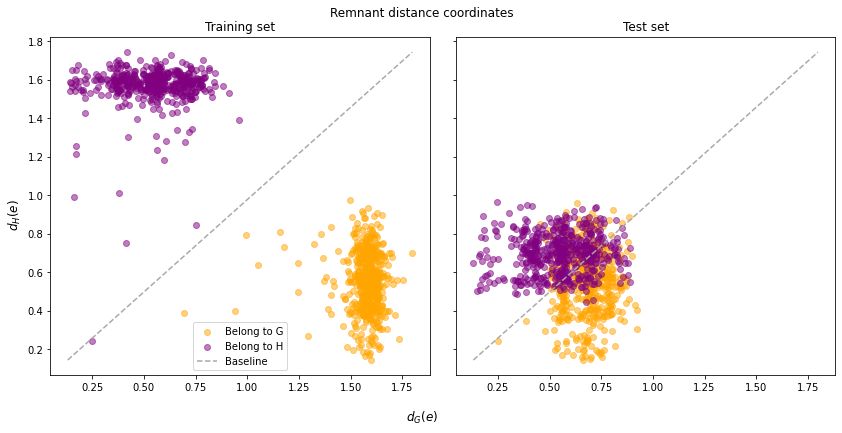

In [284]:
# Figure level initialization
fig, ax = plt.subplots(
    1, 2,
    sharex=True, sharey=True,
    figsize=(12,6)
)

fig.suptitle("Remnant distance coordinates")
fig.supxlabel("$d_G(e)$")
fig.supylabel("$d_H(e)$")
fig.tight_layout()

# Left facet - Training data
ax[0].scatter(*points_train_G, label="Belong to G", color="orange", alpha=0.5)
ax[0].scatter(*points_train_H, label="Belong to H", color="purple", alpha=0.5)
ax[0].plot(xrange, yrange, label="Baseline", color="darkgray", linestyle="--")
ax[0].legend()
ax[0].set_title("Training set")

# Right facet - test data
ax[1].scatter(*points_test_G, label="Belong to G", color="orange", alpha=0.5)
ax[1].scatter(*points_test_H, label="Belong to H", color="purple", alpha=0.5)
ax[1].plot(xrange, yrange, label="Baseline", color="darkgray", linestyle="--")
ax[1].set_title("Test set")

Text(0.5, 1.0, 'Aggregate-normalized embedding vectors')

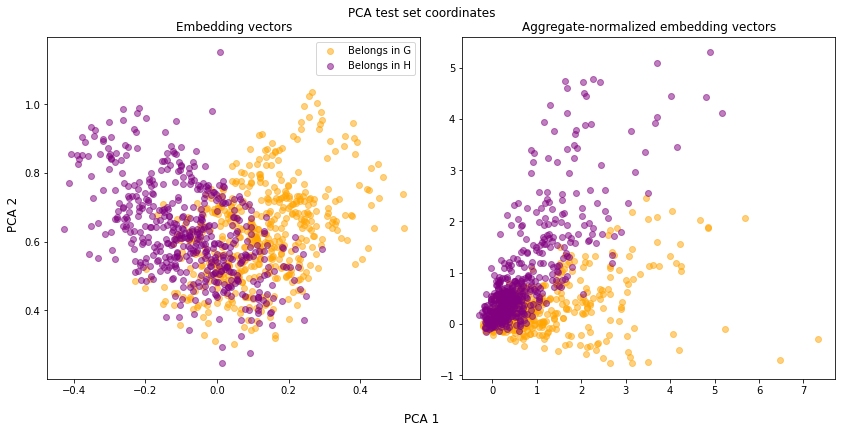

In [285]:
# Figure level initialization
fig, ax = plt.subplots(
    1, 2,
    sharex=False, sharey=False,
    figsize=(12,6)
)
fig.suptitle("PCA test set coordinates")
fig.supxlabel("PCA 1")
fig.supylabel("PCA 2")
fig.tight_layout()

# Left facet - PCA vectors
ax[0].scatter(X_test_reduced_G[0], X_test_reduced_G[1], label="Belongs in G", color="orange", alpha=0.5)
ax[0].scatter(X_test_reduced_H[0], X_test_reduced_H[1], label="Belongs in H", color="purple", alpha=0.5)
ax[0].legend()
ax[0].set_title("Embedding vectors")

# Right facet - PCA normalized vectors
ax[1].scatter(X_test_normalized_reduced_G[0], X_test_normalized_reduced_G[1], label="Belongs in G", color="orange", alpha=0.5)
ax[1].scatter(X_test_normalized_reduced_H[0], X_test_normalized_reduced_H[1], label="Belongs in H", color="purple", alpha=0.5)
ax[1].set_title("Aggregate-normalized embedding vectors")

## Fitted model

Text(0.5, 1.0, 'Layer origination as a function of distance quotient\nModel score: 0.7613')

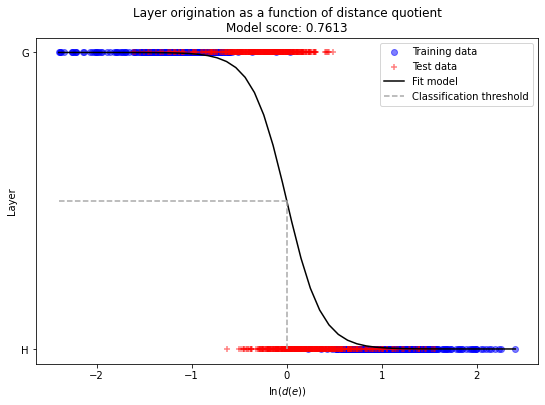

In [286]:
plt.figure(figsize=(9,6))

expit = lambda x: 1 / (1 + np.exp(-x*coef[0] - intercept[0]))
xmin = min(min(distance_ratios_train), min(distance_ratios_test))
xmax = max(max(distance_ratios_train), max(distance_ratios_test))
xrange = np.linspace(xmin, xmax)

plt.scatter(distance_ratios_train, labels_train, label="Training data", color="blue", marker="o", alpha=0.5)
plt.scatter(distance_ratios_test, labels_test, label="Test data", color="red", marker="+", alpha=0.5)

plt.plot(xrange, [expit(x) for x in xrange], label="Fit model", color="black")

model_inv_threshold = -intercept[0]/coef[0]
plt.vlines(model_inv_threshold, 0, 0.5, label="Classification threshold", linestyle="--", color="darkgray")
plt.hlines(0.5, xmin, model_inv_threshold, linestyle="--", color="darkgray")

plt.legend()

plt.xlabel("$\\ln ( d(e) )$")
plt.ylabel("Layer")
plt.yticks([0,1], labels=["H", "G"])
plt.title(f"Layer origination as a function of distance quotient\nModel score: {model.score(distance_ratios_test, labels_test):.4f}")